# **Visualization of CNNs: Grad-CAM**
* **Objective**: Convolutional Neural Networks are widely used on computer vision. They are powerful for processing grid-like data. However we hardly know how and why they work, due to the lack of decomposability into individually intuitive components. In this assignment, we use Grad-CAM, which highlights the regions of the input image that were important for the neural network prediction.


* NB: if `PIL` is not installed, try `conda install pillow`.
* Computations are light enough to be done on CPU.

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import pickle
import urllib.request

import numpy as np
from PIL import Image
import cv2

%matplotlib inline

## Download the Model
We provide you with a model `DenseNet-121`, already pretrained on the `ImageNet` classification dataset.
* **ImageNet**: A large dataset of photographs with 1 000 classes.
* **DenseNet-121**: A deep architecture for image classification (https://arxiv.org/abs/1608.06993)

In [181]:
densenet121 = models.densenet121(pretrained=True)
densenet121.eval() # set the model to evaluation model
pass

In [182]:
classes = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))

##classes is a dictionary with the name of each class 
print(classes)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

## Input Images
We provide you with 20 images from ImageNet (download link on the webpage of the course or download directly using the following command line,).<br>
In order to use the pretrained model resnet34, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(224, 224)`.

In [183]:
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    # Note: If the inverse normalisation is required, apply 1/x to the above object
    
    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)

In [184]:
import os
if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("data/TP2_images"):
    os.mkdir("data/TP2_images")
    !cd data/TP2_images && curl.exe -o TP2_images "https://www.lri.fr/~gcharpia/deeppractice/2025/TP2/TP2_images.zip" && unzip TP2_images.zip

dir_path = "data/" 
dataset = preprocess_image(dir_path)

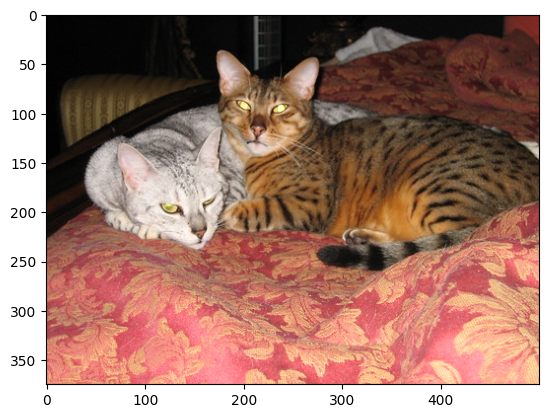

In [185]:
# show the orignal image 
index = 5
input_image = Image.open(dataset.imgs[index][0]).convert('RGB')
plt.imshow(input_image)

In [186]:
input_image = dataset[index][0].view(1, 3, 224, 224)
output = densenet121(input_image)
values, indices = torch.topk(output, 3)
print("Top 3-classes:", indices[0].numpy(), [classes[x] for x in indices[0].numpy()])
print("Raw class scores:", values[0].detach().numpy())

Top 3-classes: [285 281 282] ['Egyptian cat', 'tabby, tabby cat', 'tiger cat']
Raw class scores: [11.897001 10.01659   9.185299]


# Grad-CAM 
* **Overview:** Given an image, and a category (‘tiger cat’) as input, we forward-propagate the image through the model to obtain the `raw class scores` before softmax. The gradients are set to zero for all classes except the desired class (tiger cat), which is set to 1. This signal is then backpropagated to the `rectified convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).


* **To Do**: Define your own function Grad_CAM to achieve the visualization of the given images. For each image, choose the top-3 possible labels as the desired classes. Compare the heatmaps of the three classes, and conclude. 

More precisely, you should provide a function: `show_grad_cam(image: torch.tensor) -> None` that displays something like this:
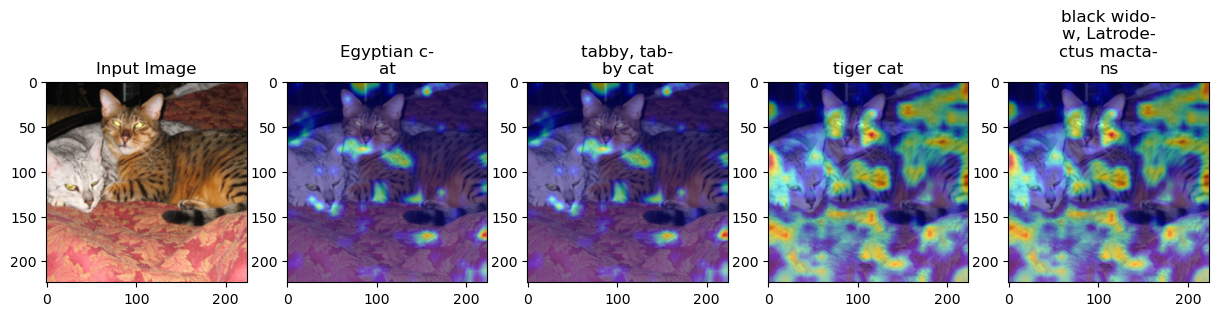
where the heatmap will be correct (here it is just an example) and the first 3 classes are the top-3 predicted classes and the last is the least probable class according to the model.

* **Comment your code**: Your code should be easy to read and follow. Please comment your code, try to use the NumPy Style Python docstrings for your functions.

* **To be submitted within 2 weeks**: this notebook, **cleaned** (i.e. without results, for file size reasons: `menu > kernel > restart and clean`), in a state ready to be executed (with or without GPU) (if one just presses 'Enter' till the end, one should obtain all the results for all images) with a few comments at the end. No additional report, just the notebook!


* **Hints**: 
 + We need to record the output and grad_output of the feature maps to achieve Grad-CAM. In pytorch, the function `Hook` is defined for this purpose. Read the tutorial of [hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) carefully.
 + More on [autograd](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html) and [hooks](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks)
 + The pretrained model densenet doesn't have an activation function after its last layer, the output is indeed the `raw class scores`, you can use them directly. 
 + Your heatmap will have the same size as the feature map. You need to scale up the heatmap to the resized image (224x224, not the original one, before the normalization) for better observation purposes. The function [`torch.nn.functional.interpolate`](https://pytorch.org/docs/stable/nn.functional.html?highlight=interpolate#torch.nn.functional.interpolate) may help.  
 + Here is the link to the paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

Class: ‘pug, pug-dog’ | Class: ‘tabby, tabby cat’
- | - 
![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/dog.jpg)| ![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/cat.jpg)

## Part 1: Grad-CAM implementation

In [349]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load a pre-trained DenseNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet121(pretrained=True).to(device)
model.eval()

# Hook for feature map and gradients
class LayerHook:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer_name = target_layer
        self.feature_map = None
        self.gradient = None
        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.feature_map = output.detach()
        
        def backward_hook(module, grad_in, grad_out):
            self.gradient = grad_out[0].detach()
    
        layer = dict(model.features.named_children())['denseblock4']['denselayer16'].conv2
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)


# Generate Grad-CAM heatmap
def generate_grad_cam(image, extractor, target_class):
    model.zero_grad()
    output = model(image)
    class_score = output[0, target_class]
    class_score.backward()
    gradients = extractor.gradient
    feature_map = extractor.feature_map
    weights = gradients.mean(dim=[0, 2, 3], keepdim=True)
    cam = (weights * feature_map).sum(dim=1, keepdim=True)
    cam = F.relu(cam)  # ReLU to remove negative values
    cam = F.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
    cam /= torch.max(cam) # Normalize between 0 and 1
    return cam.squeeze().cpu().numpy()

# Overlay heatmap on original image
def overlay_heatmap(image, heatmap):
    image = image.resize((224, 224))
    heatmap = Image.fromarray(np.uint8(plt.cm.viridis(heatmap) * 255)).convert("RGB")
    heatmap = heatmap.resize((224, 224), Image.LANCZOS)
    blended = Image.blend(image.convert("RGB"), heatmap, alpha=0.6)
    return blended

# Show Grad-CAM visualizations
def show_grad_cam(model, original_image, image):
    extractor = LayerHook(model, 'norm5')  # Targeting the last conv layer
    # Get top-3 predicted classes and least probable class
    output = model(image)
    probabilities = F.softmax(output, dim=1)[0]
    top_classes = probabilities.topk(3).indices.cpu().numpy()
    
    original_image = original_image.resize((224, 224))
    # Generate heatmaps
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(original_image)
    axes[0].set_title("Input Image")
    
    for i, class_idx in enumerate(list(top_classes)):
        heatmap = generate_grad_cam(image, extractor, class_idx)
        overlay = overlay_heatmap(original_image, heatmap)
        axes[i+1].imshow(overlay)
        axes[i+1].set_title(f"Class {classes[class_idx]}")
    
    plt.show()


## Part 2: Try it on a few (1 to 3) images and comment

TypeError: show_grad_cam() got an unexpected keyword argument 'image'

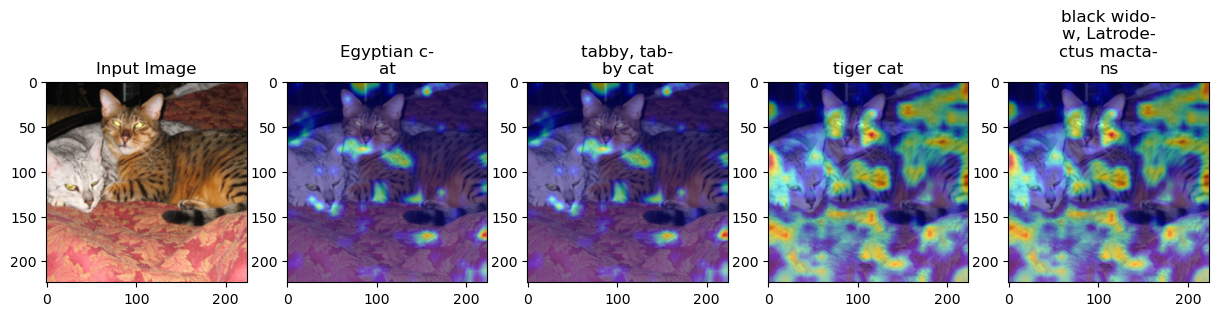

c:\Users\tlc29\Documents\CS\3A\DLIP\dlip-env\lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


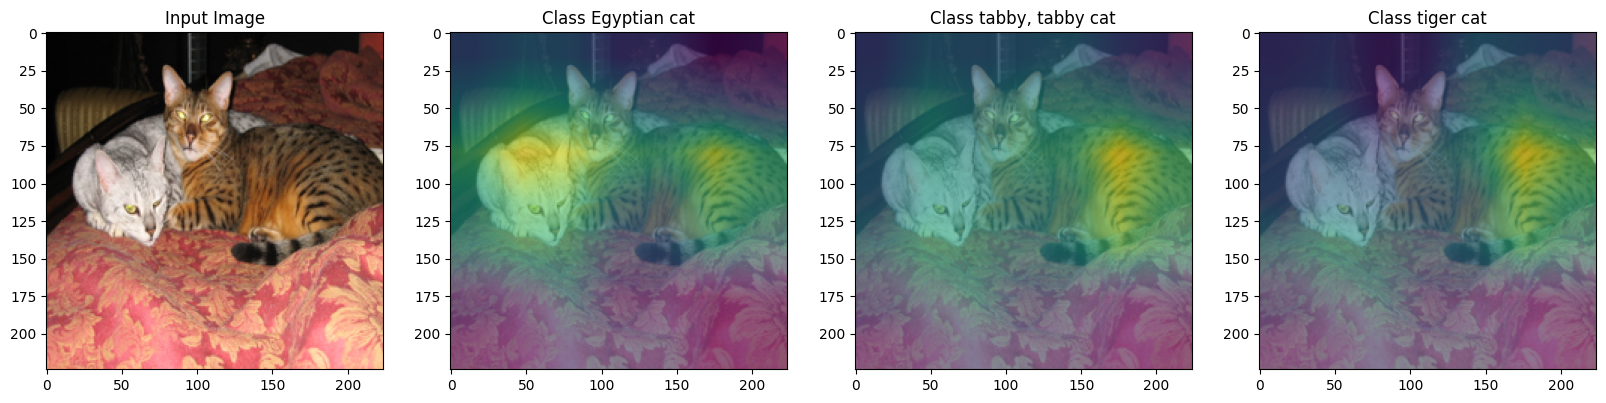

In [343]:
index = 5
first_image = Image.open(dataset.imgs[index][0]).convert('RGB')
input_image = dataset[index][0].view(1, 3, 224, 224)
show_grad_cam(densenet121, first_image, input_image)

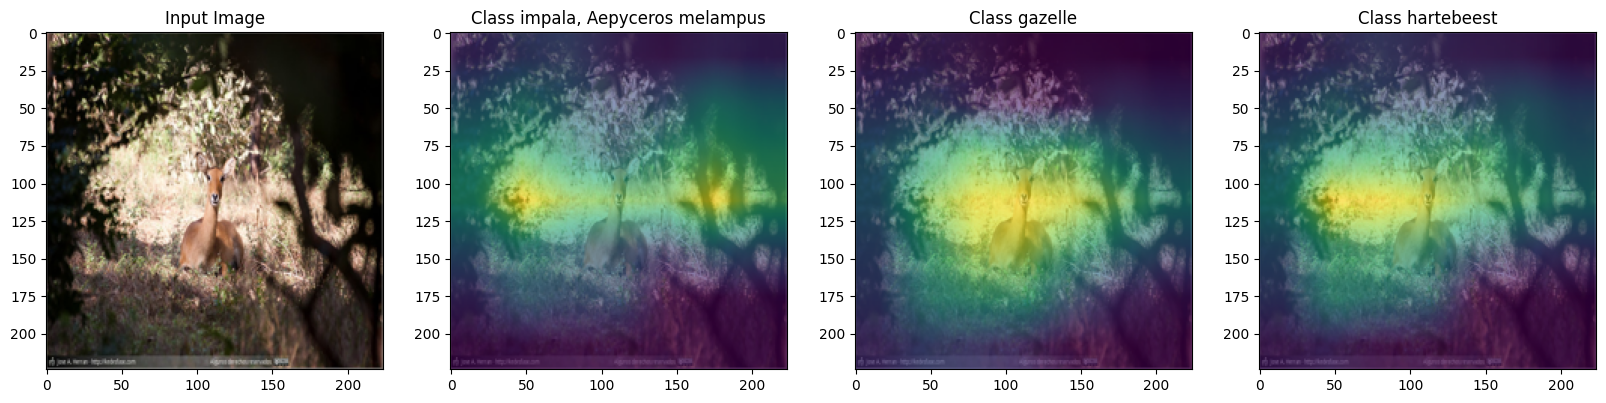

In [346]:
index = 13
second_image = Image.open(dataset.imgs[index][0]).convert('RGB')
input_image = dataset[index][0].view(1, 3, 224, 224)
show_grad_cam(densenet121, second_image, input_image)

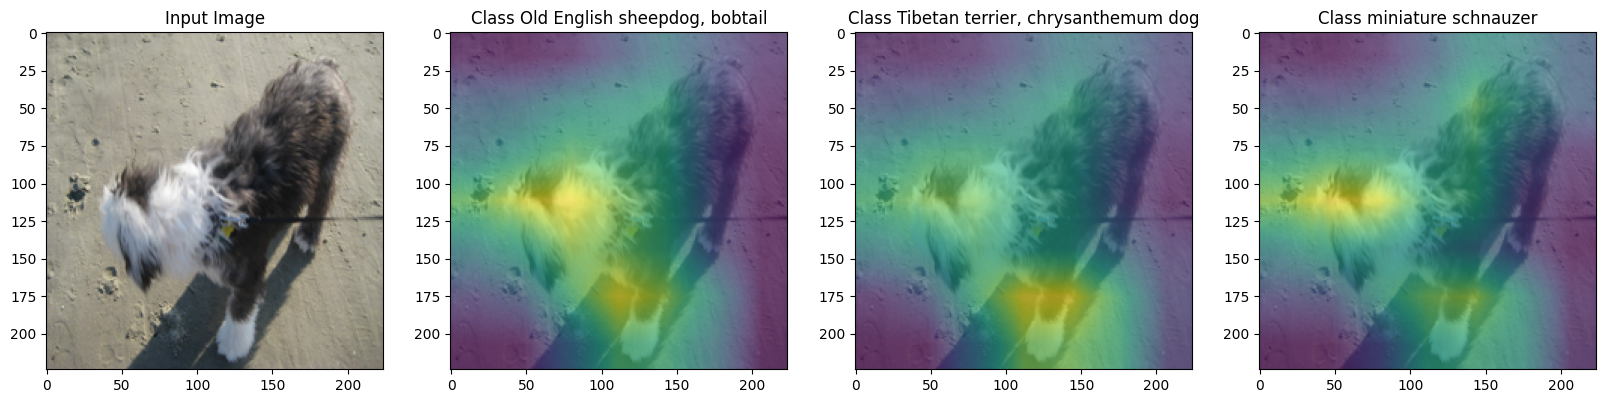

In [347]:
index = 2
second_image = Image.open(dataset.imgs[index][0]).convert('RGB')
input_image = dataset[index][0].view(1, 3, 224, 224)
show_grad_cam(densenet121, second_image, input_image)

## Part 3: Try GradCAM on others convolutional layers, describe and comment the results

In [375]:
ResNet50 = models.resnet50(pretrained=True).to(device)
ResNet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [396]:
dict(ResNet50.named_children())['layer4'][-1].conv3

Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)

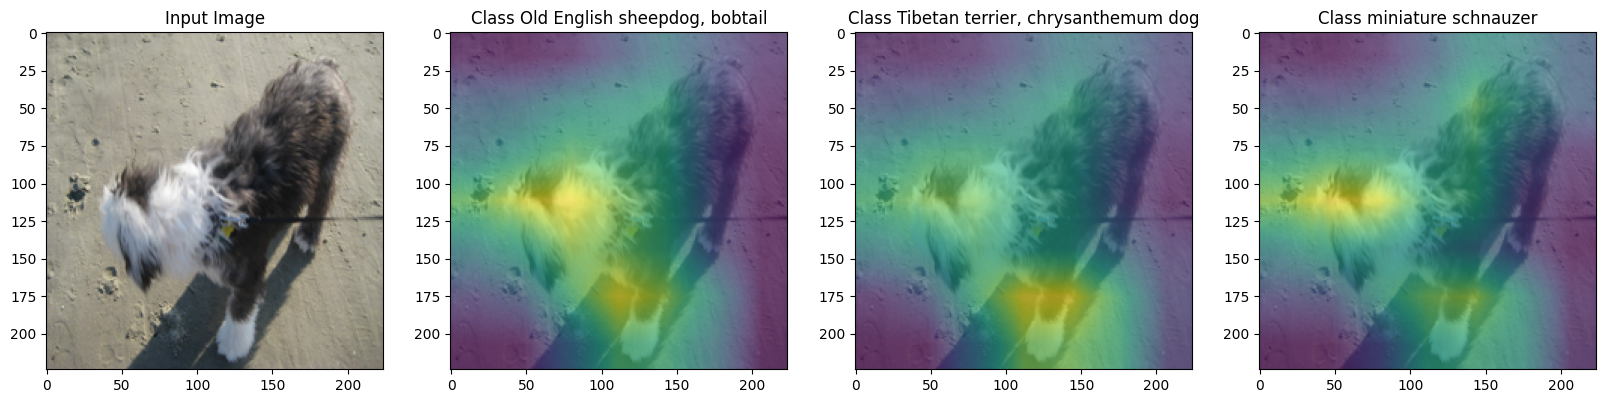

In [376]:
index = 2
first_image = Image.open(dataset.imgs[index][0]).convert('RGB')
input_image = dataset[index][0].view(1, 3, 224, 224)
show_grad_cam(densenet121, first_image, input_image)

## Part 4: Try GradCAM on `9928031928.png` , describe and comment the results

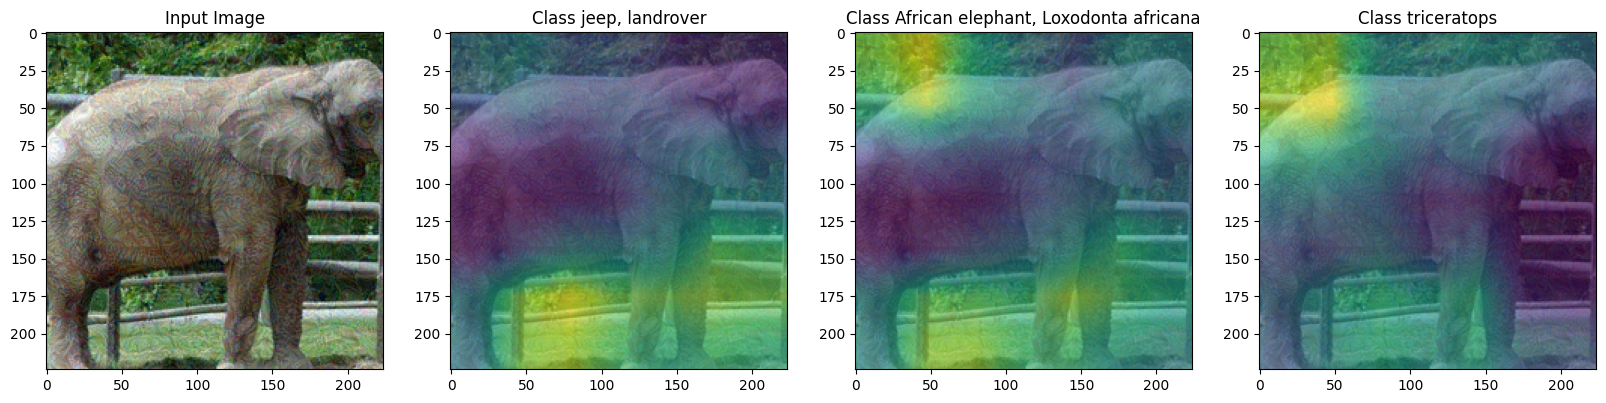

In [367]:
# Your code here
index = 20
part_4_image = Image.open(dataset.imgs[index][0]).convert('RGB')
input_image = dataset[index][0].view(1, 3, 224, 224)
show_grad_cam(densenet121, part_4_image, input_image)

## Part 5: What are the principal contributions of GradCAM (the answer is in the paper) ?

## Bonus 5: What are the main differences between DenseNet and ResNet ?